In [1]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
from pipeline import load_annoataion,generator_synth,get_batch_synth,generator,get_batch,generator_a,generator_i
import cv2
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pathlib
import pandas as pd
import os
from Levenshtein import distance
from enque import GeneratorEnqueuer
from itertools import compress
# from shapely.geometry import Polygon
import time
import random
import threading
import multiprocessing
import config
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from utils import check_and_validate_polys, crop_area, rotate_image, generate_rbox,generate_r, get_project_matrix_and_width, sparse_tuple_from, crop_area_fix

from roi import roi_rotate_tensor_pad as roi
#model related imports
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2,ResNet50,DenseNet121
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
tf.executing_eagerly()
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,BatchNormalization,Concatenate,Conv2D,AveragePooling2D,Conv2DTranspose,UpSampling2D,Lambda,Bidirectional,LSTM,MaxPool2D,Reshape
def return_names(root_dir,str1):
    data_root = pathlib.Path(root_dir)
    print("root is",data_root)
    all_pics_path=list(data_root.glob("**/*."+ str1))
    all_pics_path=[str(path) for path in all_pics_path]
    dict1={str1: all_pics_path}

    data_df=pd.DataFrame(dict1)
    return data_df


import tensorflow_addons as tfa
tfa_enabled = False

def label_to_array(label):
    try:
        label = label.replace(' ', '')
        return [CHAR_VECTOR.index(x) for x in label]
    except Exception as ex:
        print(label)
        raise ex
CHAR_VECTOR = "#0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMÉNOPQRSTUVWXYZ-~`´<>'.:;^/|!?$%@&*()[]{}_+=,\\\""
num_classes=len(CHAR_VECTOR)+1
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
num_classes

97

In [3]:
tf.test.is_built_with_cuda() 

True

In [4]:
tf.executing_eagerly()

True

# Synth 

In [5]:
file=open('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\\path_to_imgs.txt')
image_list=[]
for i in file.readlines():
    image_list.append('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\SynthText\\'+i.replace('\n',''))

In [6]:
len(image_list)

858750

# ICdar

In [7]:
rdir='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_training_images'
icdar_2015=return_names(rdir,'JPG')
rdir_test='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_test_images\\'
icdar_2015_test=return_names(rdir_test,'JPG')


g='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\ch4_training_localization_transcription_gt\\'
icdar_2015_gt=return_names(g,'txt')
g='C:\\Users\\Abhi\Desktop\\CS2\\icdar2015\\Challenge4_Test_Task1_GT\\'
icdar_2015_gt_test=return_names(g,'txt')


train=pd.concat([icdar_2015,icdar_2015_gt],axis=1)
list1=[]
for i in train['txt']:
    f = open(i, "r",encoding='utf-8')
    list1.append(f.readlines())
train['y']=list1
list5=[]
for i in train ['y']:
    list2=[]
    list3=[]
    for j in range(len(i)):
        if j ==0:
            list2.append(                      i[j][1:].split(',')[:-1])
          
            list3.append(i[j].split(',')[-1].replace('\n',''))
    
        else:
             list2.append(        i[j].split(',')[:-1])
             list3.append(i[j].split(',')[-1].replace('\n',''))
    list5.append((list2,list3))
train['label']=[i[1] for i in list5]
train['bb']=[i[0] for i in list5]
train[['label','bb']].head()

root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_training_images
root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_test_images
root is C:\Users\Abhi\Desktop\CS2\icdar2015\ch4_training_localization_transcription_gt
root is C:\Users\Abhi\Desktop\CS2\icdar2015\Challenge4_Test_Task1_GT


,label,bb
0,"[Genaxis Theatre, [06], ###, 62-03, Carpark, #...","[[377, 117, 463, 117, 465, 130, 378, 130], [49..."
1,"[###, HarbourFront, CC22, bua, ###, ###, ###, ...","[[261, 138, 284, 140, 279, 158, 260, 158], [28..."
2,"[Way, out, ###, Line, Platform, ###, ###, ###]","[[645, 19, 686, 13, 692, 43, 651, 48], [689, 1..."
3,"[###, ###, ###, ###]","[[486, 216, 554, 211, 558, 243, 489, 248], [1,..."
4,"[CARE, STICKER, FOR, ###, MORE, ###, ###, ###,...","[[899, 214, 928, 213, 928, 241, 900, 242], [93..."


#Generator for Recohnition

In [ ]:

def generator_i(train=train, input_size=512, batch_size=1):
  
    image_list = np.array(train['JPG'])
    gt=np.array(train['bb'])

    index = np.arange(0, image_list.shape[0])
    while True:
        np.random.shuffle(index)
        batch_images = []
        batch_image_fns = []
        batch_score_maps = []
        batch_geo_maps = []
        batch_training_masks = []

    
    
        count = 0
        for i in index:
            try:
                im_fn = image_list[i]
                im=cv2.imread(im_fn)
                vertexlist,w,h=gt[i],im.shape[1],im.shape[0]
               
                list2=[]
                for j in range(len(vertexlist)):
                    list1=[]
                    k=0
                    while k<7:
                        list1.append((float(vertexlist[j][k]),float(vertexlist[j][k+1])))
                        k=k+2
                    list2.append(list1)
               
                

                text_tags=[]
                labels=[]
                for label in train['label'][i]:
                    if label == '*' or label == '###' or label == '':
                        text_tags.append(True)
                        labels.append([-1])
                    else:
                        labels.append(label_to_array(label))
                        text_tags.append(False)
#                 poly, text_tags, labels=load_annoataion(train['txt'][i])#
                poly=np.array(list2, dtype=np.float32)
                text_tags=np.array(text_tags)
               
                text_polys, text_tags, text_labels = check_and_validate_polys(poly, text_tags, labels, (h, w))

                ############################# Data Augmentation ##############################

                # resize the image to input size
              
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
#                 mask = [not (word == [-1]) for word in text_labels]
#                 text_labels = list(compress(text_labels, mask))
#                 rectangles = list(compress(rectangles, mask))

                if type(score_map)!=np.ndarray:
                    if score_map==None:
                        continue
#                 assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"

#                 if len(text_labels) == 0:
#                     continue

           

                count += 1

                batch_images.append(im[:, :, ::-1].astype(np.float32))
                batch_image_fns.append(im_fn)
                batch_score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                batch_geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                batch_training_masks.append(training_mask[::4, ::4, np.newaxis].astype(np.float32))

                if len(batch_images) == batch_size:

                    yield np.array(batch_images),np.concatenate([np.array(batch_score_maps), np.array(batch_geo_maps), np.array(batch_training_masks)],axis=3)
                    batch_images = []
                    batch_image_fns = []
                    batch_score_maps = []
                    batch_geo_maps = []
                    batch_training_masks = []
                  
                    count = 0
            except Exception as e:
                import traceback
              
                traceback.print_exc()
                continue




#****************************************************************************************************************************


def generator_a(image_list=image_list, input_size=512, batch_size=1):
    
        
    index = np.arange(0, len(image_list))
    while True:
        np.random.shuffle(index)
        batch_images = []
        batch_image_fns = []
        batch_score_maps = []
        batch_geo_maps = []
        batch_training_masks = []

        count = 0
        for i in index:
            try:
                im_fn = image_list[i]
                im=cv2.imread(im_fn)
                
                poly, text_tags, labels=load_annoataion('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\\annotation\\'+image_list[i].split('/')[1].split('.')[0]+'.txt')
            
                h,w=im.shape[0],im.shape[1]
                text_polys, text_tags, text_labels = check_and_validate_polys(poly, text_tags, labels, (h, w))

                ############################# Data Augmentation ##############################
                # random scale this image
               

                # resize the image to input size
                new_h, new_w, _ = im.shape
            
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
          
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
               
                score_map, geo_map, training_mask, _,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
             
#                 mask = [not (word == [-1]) for word in text_labels]
#                 text_labels = list(compress(text_labels, mask))
#                 rectangles = list(compress(rectangles, mask))
                if type(score_map)!=np.ndarray:
                    if score_map==None:
                        continue

      
              
#                 assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"

#                 if len(text_labels) == 0:
#                     continue

#                 boxes_mask = np.array([count] * len(rectangles))

                count += 1

                batch_images.append(im)
              
                batch_image_fns.append(im_fn)
                batch_score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                batch_geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                batch_training_masks.append(training_mask[::4, ::4, np.newaxis].astype(np.float32))
           

                if len(batch_images) == batch_size:
#                   
                    yield np.array(batch_images),np.concatenate([np.array(batch_score_maps), np.array(batch_geo_maps), np.array(batch_training_masks)],axis=3)

                    batch_images = []
                    batch_image_fns = []
                    batch_score_maps = []
                    batch_geo_maps = []
                    batch_training_masks = []
        
                    count = 0
            except Exception as e:
                import traceback
              
                traceback.print_exc()
                continue


In [33]:
dataset = tf.data.Dataset.from_generator(
    generator_a,
     (tf.float32,tf.float32))
dataset = dataset.cache()

In [34]:
for i in dataset:
    print(i[0].shape)
    break

(1, 512, 512, 3)


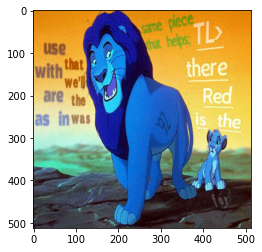

In [35]:
plt.imshow(i[0][0]/255)

# Models

In [2]:
class Detector(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.pred_score_map = Conv2D(1, (1, 1), activation='sigmoid', name='pred_score_map')
        self.rbox_geo_map = Conv2D(4, (1, 1), activation='sigmoid', name='rbox_geo_map')
        self.scale_rbox_geo_map = Lambda(lambda x: x * 512)
        self.angle_map = Conv2D(1, (1, 1), activation='sigmoid', name='rbox_angle_map')
        self.scale_angle_map = Lambda(lambda x: (x - 0.5) * np.pi / 2)
    def call(self,backbone):
        z = self.pred_score_map(backbone)
        x= self.rbox_geo_map(backbone)
        x= self.scale_rbox_geo_map(x)
        
        y=self.angle_map(backbone) 
        y=  self.scale_angle_map(y)
        zxy= Concatenate(axis=-1,name='pred_geo_map')([z,x,y])
        return zxy
    
# class Detection(Model):
#     def __init__(self,input_size):
#         super().__init__() # https://stackoverflow.com/a/27134600/4084039
        
#         self.detector=Detector()
        
        
#     def call(self, data):
      
#         score_map,geo_map=self.detector(data)
#         return  score_map,geo_map
# model_detection=Detection(512)

In [3]:
tf.keras.backend.clear_session()                                    #east https://arxiv.org/pdf/1704.03155v2.pdf
input_shape=(512,512,3)
input_layer = Input(shape=input_shape,name = 'image_input')
net=DenseNet121(input_tensor=input_layer,weights="imagenet",include_top=False,  input_shape=input_shape)
net.trainable=True
# layer=net.get_layer('pool4_conv').output

# x = UpSampling2D(size=[2, 2])(layer)
# x = UpSampling2D(size=[2, 2])(x)

# x= Conv2D(64, (1, 1), activation='relu')(x)

layer=net.get_layer('relu').output

l=['pool4_conv','pool3_conv','pool2_conv']
layer_2, layer_3, layer_4=[net.get_layer(i).output for i in l]

# x=net(input_layer)

layer_1 = UpSampling2D(size=[2, 2],interpolation='bilinear')(layer)

x = Conv2D(filters=128, kernel_size=1, padding='same')(tf.concat([layer_1, layer_2], axis=-1))
x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization( momentum=0.997, epsilon=0.00001)(x)
x = Activation('relu')(x)
x=Dropout(.2)(x)
x = UpSampling2D(size=[2, 2],interpolation='bilinear')(x)


x = Conv2D(filters=64, kernel_size=1, padding='same')(tf.concat([x, layer_3], axis=-1))
x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization( momentum=0.997, epsilon=0.00001)(x)
x = Activation('relu')(x)
x=Dropout(.2)(x)
x = UpSampling2D(size=[2, 2],interpolation='bilinear')(x)



x = Conv2D(filters=32, kernel_size=1, padding='same')(tf.concat([x, layer_4], axis=-1))
x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = BatchNormalization( momentum=0.997, epsilon=0.00001)(x)
x = Activation('relu')(x)
x=Dropout(.2)(x)
x=Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)


# x=UpSampling2D(2,interpolation='bilinear',data_format='channels_last')(x)
# x=Conv2D(32,3,padding='same')(x)
# x=BatchNormalization()(x)
# x=Activation('relu')(x)
# x=Dropout(.2)(x)



# x=UpSampling2D(2,interpolation='bilinear',data_format='channels_last')(x)
# x=Conv2D(32,3,padding='same')(x)
# x=BatchNormalization()(x)
# x=Activation('relu')(x)
# x=Dropout(.2)(x)
detector=Detector()
# Backbone = Model(inputs=[input_layer], outputs=[x])
# d.summary()
out=detector(x)

d = Model(inputs=[input_layer], outputs=[out])
# Backbone.summary()
d.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [27]:

def dice_loss(y_true_class,y_pred_class,training_mask):    # why dice loss ?  Ans:-https://stats.stackexchange.com/questions/321460/dice-coefficient-loss-function-vs-cross-entropy
    # we  are taking intersecting pixels ignoring pixels in training masks
    intersection=tf.reduce_sum(y_true_class*y_pred_class*training_mask)
    # calculating sum of total pixels where pixel is text
    union=tf.reduce_sum(y_true_class*training_mask)+tf.reduce_sum(y_pred_class*training_mask)
    eps=10**-7
    # calculating dice loss
    dice_loss_=1.0-(2*(intersection/(union+eps)))
    return dice_loss_
def loss_classification2(f_score, f_score_, training_mask):
    
    

        loss = tf.keras.losses.binary_crossentropy(f_score * training_mask,
                                                   f_score_ * training_mask,
                                                   from_logits=False,
                                                   label_smoothing=0)
        return tf.reduce_mean(loss)
class detection_loss(tf.keras.losses.Loss):
    def __init__(self,reduction=tf.keras.losses.Reduction.AUTO, name=None):
        super().__init__(reduction=reduction, name=name)
    def call(self,y_true,y_pred):
        y_true_score=y_true[:,:,:,0]
        y_pred_score=y_pred[:,:,:,0]
        y_true_geo=y_true[:,:,:,1:6]
        y_pred_geo=y_pred[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]
        loss_for_score=dice_loss(y_true_score,y_pred_score,training_mask)
        #print(loss_for_score.shape)
        loss_for_score*=0.01
        # print(tf.math.equal(tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)[0],45))
        d_t_gt, d_r_gt, d_b_gt, d_l_gt, angle_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
        d_t_pd, d_r_pd, d_b_pd, d_l_pd, angle_pd = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)
        # calculating area regarding each pixels with the help of hight and width
        area_pred= (d_t_pd+d_b_pd)*(d_r_pd+d_l_pd)
        # calculating area of original text area
        area_real= (d_t_gt+d_b_gt)*(d_r_gt+d_l_gt)
        # calculating intersected rectangle width
        width_intersected_rectangle=tf.minimum(d_r_gt,d_r_pd) + tf.minimum(d_l_gt,d_l_pd)
        # calculating intersected rectangle height
        height_intersected_rectangle=tf.minimum(d_t_gt,d_t_pd) + tf.minimum(d_b_gt,d_b_pd)
        # intersected area by multiplying intersected height snd intersected width
        intersected_area=width_intersected_rectangle*height_intersected_rectangle
        # total area which belongs to both actual text and the predicted text
        union_area=area_pred+area_real-intersected_area
        # calculating iou
        loss_iou=-tf.math.log((intersected_area+1)/(union_area+1))
        # calculating angle loss
        angle_loss=1-tf.cos(angle_pd-angle_gt)
        final_loss= (loss_iou)+(20*angle_loss)
        #print(final_loss.shape)
        final_loss=tf.squeeze(final_loss,axis=3)
        return 100*(tf.reduce_mean(final_loss*y_true_score*training_mask)+(loss_for_score))
    
    
d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,amsgrad=True),loss=detection_loss())
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='detection_logs',write_images=True,histogram_freq=1,write_graph=False)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=10,mode='min',verbose=1)
modelchkpt=tf.keras.callbacks.ModelCheckpoint('detector_model.h5',save_best_only=True,mode='min',monitor='loss')
g=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.5,patience=3,verbose=True)
callbacks=[tensorboard,early_stop,modelchkpt,g]




In [31]:
d.fit(dataset.repeat(),epochs=5,steps_per_epoch=300,callbacks=callbacks)

Epoch 1/5
300/300 [==============================] - 350s 1s/step - loss: 9.8646
Epoch 2/5
300/300 [==============================] - 331s 1s/step - loss: 5.4967
Epoch 3/5
300/300 [==============================] - 306s 1s/step - loss: 4.8601
Epoch 4/5
300/300 [==============================] - 306s 1s/step - loss: 4.9173
Epoch 5/5
300/300 [==============================] - 343s 1s/step - loss: 5.1144

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


In [32]:
d.save_weights('synth.h5')

In [16]:
d.load_weights('synth.h5')

In [12]:
dataset = tf.data.Dataset.from_generator(
    generator_i,
     (tf.float32,tf.float32))
dataset = dataset.cache()

In [4]:
d.load_weights('detector_model.h5')

In [ ]:
d.fit(dataset.repeat(),epochs=50,steps_per_epoch=300,callbacks=callbacks)

Epoch 1/50
283/300 [===========================>..] - ETA: 8s - loss: 1.7018

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 172s 507ms/step - loss: 1.7005
Epoch 2/50
300/300 [==============================] - 142s 473ms/step - loss: 1.5952
Epoch 3/50
300/300 [==============================] - 153s 512ms/step - loss: 1.6224
Epoch 4/50
 19/300 [>.............................] - ETA: 2:51 - loss: 2.1629Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 160s 535ms/step - loss: 1.8553
Epoch 5/50
300/300 [==============================] - 143s 474ms/step - loss: 1.5410
Epoch 6/50
 19/300 [>.............................] - ETA: 1:45 - loss: 1.1828

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


230/300 [======================>.......] - ETA: 34s - loss: 1.3623

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 147s 490ms/step - loss: 1.3895
Epoch 7/50
300/300 [==============================] - 152s 506ms/step - loss: 1.2005
Epoch 8/50
 71/300 [======>.......................] - ETA: 1:56 - loss: 1.2764Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 155s 515ms/step - loss: 1.2327
Epoch 9/50
139/300 [============>.................] - ETA: 1:20 - loss: 1.0217

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 148s 492ms/step - loss: 0.9867
Epoch 10/50
300/300 [==============================] - 147s 490ms/step - loss: 1.0518
Epoch 11/50
191/300 [==================>...........] - ETA: 52s - loss: 0.8870Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 146s 488ms/step - loss: 0.8896
Epoch 12/50
300/300 [==============================] - 154s 514ms/step - loss: 0.9593
Epoch 13/50
142/300 [=============>................] - ETA: 1:13 - loss: 0.8756

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 156s 520ms/step - loss: 0.8565
Epoch 14/50
206/300 [===================>..........] - ETA: 50s - loss: 0.8339

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 158s 528ms/step - loss: 0.8387
Epoch 15/50
292/300 [============================>.] - ETA: 4s - loss: 0.7559Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 154s 513ms/step - loss: 0.7564
Epoch 16/50
300/300 [==============================] - 154s 512ms/step - loss: 0.8172
Epoch 17/50
300/300 [==============================] - 147s 490ms/step - loss: 0.7498
Epoch 18/50
 96/300 [========>.....................] - ETA: 1:42 - loss: 0.9214

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 155s 519ms/step - loss: 0.7911
Epoch 19/50
 49/300 [===>..........................] - ETA: 2:07 - loss: 0.6022Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 147s 491ms/step - loss: 0.6555
Epoch 20/50
300/300 [==============================] - 153s 510ms/step - loss: 0.7844
Epoch 21/50
 87/300 [=======>......................] - ETA: 1:48 - loss: 0.6853

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 159s 530ms/step - loss: 0.7068
Epoch 22/50
 50/300 [====>.........................] - ETA: 2:08 - loss: 0.6107Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 145s 484ms/step - loss: 0.6006
Epoch 23/50
300/300 [==============================] - 147s 490ms/step - loss: 0.6111
Epoch 24/50
139/300 [============>.................] - ETA: 1:22 - loss: 0.6468

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 154s 512ms/step - loss: 0.6396
Epoch 25/50
300/300 [==============================] - 154s 514ms/step - loss: 0.5552
Epoch 26/50
300/300 [==============================] - 147s 490ms/step - loss: 0.5902
Epoch 27/50
123/300 [===========>..................] - ETA: 1:28 - loss: 0.5757Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 150s 500ms/step - loss: 0.5659
Epoch 28/50
300/300 [==============================] - 149s 498ms/step - loss: 0.5508
Epoch 29/50
300/300 [==============================] - 151s 504ms/step - loss: 0.5169
Epoch 30/50
 50/300 [====>.........................] - ETA: 2:08 - loss: 0.4567

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


179/300 [================>.............] - ETA: 1:03 - loss: 0.5405Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 157s 523ms/step - loss: 0.5521
Epoch 31/50
247/300 [=======================>......] - ETA: 26s - loss: 0.5316Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 150s 499ms/step - loss: 0.5345
Epoch 32/50
300/300 [==============================] - 154s 512ms/step - loss: 0.4953
Epoch 33/50
 85/300 [=======>......................] - ETA: 2:00 - loss: 0.5816

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 153s 510ms/step - loss: 0.5675
Epoch 34/50
300/300 [==============================] - 154s 511ms/step - loss: 0.5277
Epoch 35/50
141/300 [=============>................] - ETA: 1:20 - loss: 0.4727

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 150s 498ms/step - loss: 0.4733
Epoch 36/50
300/300 [==============================] - 159s 530ms/step - loss: 0.5164
Epoch 37/50
177/300 [================>.............] - ETA: 1:02 - loss: 0.4628Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 152s 506ms/step - loss: 0.4551
Epoch 38/50
 31/300 [==>...........................] - ETA: 2:15 - loss: 0.5769

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


144/300 [=============>................] - ETA: 1:12 - loss: 0.4786Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 146s 485ms/step - loss: 0.4641
Epoch 39/50
300/300 [==============================] - 162s 542ms/step - loss: 0.5087
Epoch 40/50
300/300 [==============================] - 157s 525ms/step - loss: 0.4639
Epoch 41/50
300/300 [==============================] - 156s 521ms/step - loss: 0.5223
Epoch 42/50
291/300 [============================>.] - ETA: 4s - loss: 0.4168

Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 157s 523ms/step - loss: 0.4171
Epoch 43/50
211/300 [====================>.........] - ETA: 44s - loss: 0.4600Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-9-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 148s 494ms/step - loss: 0.4526
Epoch 44/50
 34/300 [==>...........................] - ETA: 2:22 - loss: 0.5997

In [35]:
d.fit(dataset.repeat(),epochs=10,steps_per_epoch=300,callbacks=callbacks)

Epoch 1/10
135/300 [============>.................] - ETA: 1:29 - loss: 0.4238

Traceback (most recent call last):
  File "<ipython-input-5-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


157/300 [==============>...............] - ETA: 1:16 - loss: 0.4204

Traceback (most recent call last):
  File "<ipython-input-5-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 161s 501ms/step - loss: 0.4073
Epoch 2/10
300/300 [==============================] - 155s 516ms/step - loss: 0.3993
Epoch 3/10
300/300 [==============================] - 156s 521ms/step - loss: 0.3534
Epoch 4/10
211/300 [====================>.........] - ETA: 48s - loss: 0.4027

Traceback (most recent call last):
  File "<ipython-input-5-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 171s 566ms/step - loss: 0.3952
Epoch 5/10
129/300 [===========>..................] - ETA: 1:29 - loss: 0.3248Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-5-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


300/300 [==============================] - 156s 519ms/step - loss: 0.3260
Epoch 6/10
300/300 [==============================] - 162s 540ms/step - loss: 0.3925
Epoch 7/10
300/300 [==============================] - 157s 519ms/step - loss: 0.3082
Epoch 8/10
300/300 [==============================] - 156s 519ms/step - loss: 0.3212
Epoch 9/10
300/300 [==============================] - 163s 541ms/step - loss: 0.3642
Epoch 10/10
 60/300 [=====>........................] - ETA: 2:32 - loss: 0.3452Cross point does not exist


Traceback (most recent call last):
  File "<ipython-input-5-48946f94f632>", line 63, in generator_i
    score_map, geo_map, training_mask,_,rectangles = generate_r((new_h, new_w), text_polys, text_tags,10)
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 722, in generate_r
    if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
  File "C:\Users\Abhi\Desktop\CS2\utils.py", line 321, in point_dist_to_line
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


173/300 [================>.............] - ETA: 1:10 - loss: 0.3673

Traceback (most recent call last):
  File "<ipython-input-5-48946f94f632>", line 60, in generator_i
    text_polys[:, :, 0] *= resize_ratio_3_x
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed


300/300 [==============================] - 163s 544ms/step - loss: 0.3680


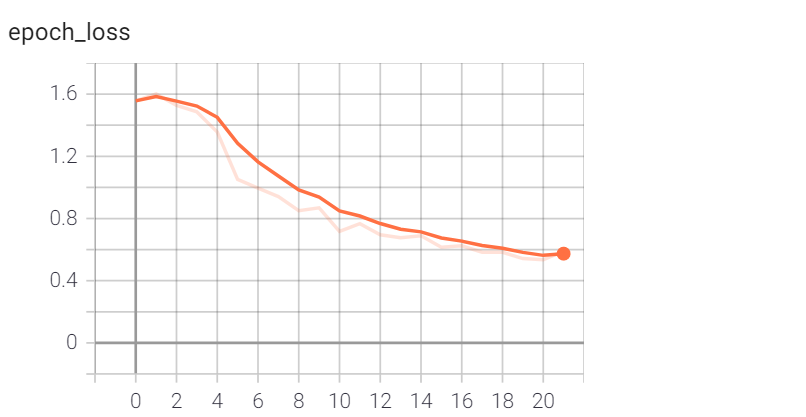

In [149]:
Image(filename='d.png')

# synth prediction

In [ ]:
for i in dataset:
    
    print(i[0].shape)
  
    pred=d.predict(i[0])


    plt.imshow(pred[0,::][:,:,0])
    plt.show()
    break

# ICDAR prediction

(1, 512, 512, 3)


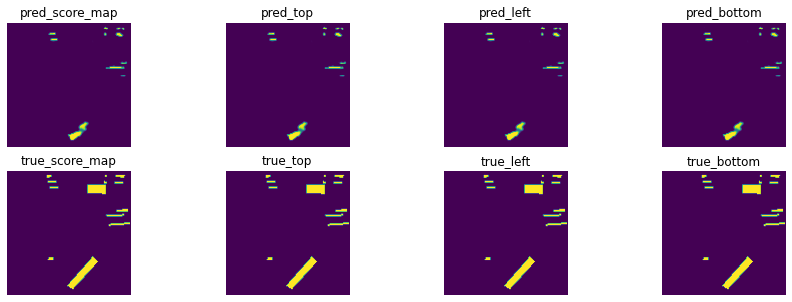

In [17]:
d.load_weights('detector_model.h5')
for i in dataset:
    
    print(i[0].shape)
  
    pred=d.predict(i[0])
    break
label=['score_map','top','left','bottom','right']
fig, ax = plt.subplots(2,4,figsize=(15,5))
for j in range(1):
    for k in range(4):
                ax[0,k].imshow(pred[0,::][:,:,0])             
                ax[1,k].imshow(i[1][0,::][:,:,0])
                ax[0,k].set_title('pred_'+label[k])            
                ax[1,k].set_title('true_'+label[k])      
                ax[0,k].axis("off")
                ax[1,k].axis('off')

# Recognition

# ICDAR

In [72]:
def generator_text(df, batch_size=12, random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2]),):
    
    count = 1
    images_with_label={}
    l=[]
    images=[]
    gt=np.array(train['bb'])

    index=range(train.shape[0])
    for i in tqdm(index):
        
            im_fn = np.array(train['JPG'])[i]
            im=cv2.imread(im_fn)
            vertexlist,w,h=gt[i],im.shape[1],im.shape[0]
               
            list2=[]
            for j in range(len(vertexlist)):
                list1=[]
                k=0
                while k<7:
                    list1.append((float(vertexlist[j][k]),float(vertexlist[j][k+1])))
                    k=k+2
                list2.append(list1)
               
                

            text_tags=[]
            labels=[]
            for label in train['label'][i]:
                if label == '*' or label == '###' or label == '':
                        text_tags.append(True)
                        labels.append([-1])
                else:
                        labels.append(label_to_array(label))
                        text_tags.append(False)
#                 poly, text_tags, labels=load_annoataion(train['txt'][i])#
            poly=np.array(list2, dtype=np.float32)
            text_tags=np.array(text_tags)
               
            text_polys, text_tags, text_labels = check_and_validate_polys(poly, text_tags, labels, (h, w))

        
            rd_scale = np.random.choice(random_scale)
            im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
            text_polys *= rd_scale

        # rotate image from [-10, 10]j
            angle = random.randint(-10, 10)
#             flag=True
#             while flag:
            im1, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
#                 count+=1
#                 if len(selected_poly)==1:
#                     flag=False
#                 elif count>10:
                    
#                     flag=False
           
            count=0
       
            if len(selected_poly)==1:
                text_labels = [text_labels[i] for i in selected_poly]
              
                if text_polys.shape[0] == 0 or len(text_labels) == 0 or text_labels[0][0]==-1:
                    continue
                
                resize_h = 60
                resize_w = 64*4
                im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
                cv2.imwrite('C:\\Users\\Abhi\\Desktop\\CS2\\icdar2015\Roi\\'+im_fn.split('\\')[-1],im)
                images.append('C:\\Users\\Abhi\\Desktop\\CS2\\icdar2015\Roi\\'+im_fn.split('\\')[-1])
                l.append(text_labels[0])
            
                count=count+1
    images_with_label['labels']=l
    images_with_label['im']=images
    return images_with_label

# Synth

In [39]:
def generator_synth(df, random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2]),):
    
    count = 1
    images_with_label={}
    l=[]
    images=[]
  
        
    index = np.arange(0,len(df)//20)
  
    for i in tqdm(index):
        
            im_fn = image_list[i]
            im=cv2.imread(im_fn)
            h,w=im.shape[0],im.shape[1]
            poly, text_tags, labels=load_annoataion('C:\\Users\\Abhi\\Desktop\\CS2\\SynthText\\annotation\\'+image_list[i].split('/')[1].split('.')[0]+'.txt')
               
            text_polys, text_tags, text_labels = check_and_validate_polys(poly, text_tags, labels, (h, w))

        
            rd_scale = np.random.choice(random_scale)
            im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
            text_polys *= rd_scale

        # rotate image from [-10, 10]j
            angle = random.randint(-10, 10)

            im, text_polys, text_tags, selected_poly = crop_area(im, text_polys, text_tags, crop_background=False)
           

       
            if len(selected_poly)==1:
                text_labels = [text_labels[i] for i in selected_poly]
              
                if text_polys.shape[0] == 0 or len(text_labels) == 0 or text_labels[0][0]==-1:
                    
                    continue
                else:
                    resize_h = 60
                    resize_w = 64*4
                    im = cv2.resize(im, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
                    cv2.imwrite('C:\\Users\\Abhi\\Desktop\\CS2\\icdar2015\Roi\\'+str(i)+'.jpg',im)
                    images.append('C:\\Users\\Abhi\\Desktop\\CS2\\icdar2015\Roi\\'+str(i)+'.jpg')
                    l.append(text_labels[0])
                  
                count=count+1
    images_with_label['labels']=l
    images_with_label['im']=images
    return images_with_label

In [40]:
synth=generator_synth(image_list)

  4%|██▊                                                                          | 1588/42937 [00:21<09:01, 76.37it/s]

poly in wrong direction


 10%|███████▍                                                                     | 4126/42937 [00:52<10:51, 59.61it/s]

poly in wrong direction


 11%|████████▎                                                                    | 4627/42937 [00:58<08:04, 79.14it/s]

poly in wrong direction


 13%|██████████                                                                   | 5596/42937 [01:09<07:33, 82.30it/s]

poly in wrong direction
poly in wrong direction
poly in wrong direction


 14%|██████████▉                                                                  | 6132/42937 [01:16<07:20, 83.61it/s]

poly in wrong direction


 17%|████████████▉                                                                | 7222/42937 [01:29<07:59, 74.53it/s]

poly in wrong direction


 17%|█████████████                                                                | 7253/42937 [01:29<06:37, 89.76it/s]

poly in wrong direction


 17%|█████████████▏                                                               | 7365/42937 [01:30<07:03, 84.00it/s]

poly in wrong direction


 21%|███████████████▉                                                             | 8884/42937 [01:49<07:20, 77.34it/s]

poly in wrong direction


 21%|████████████████▌                                                            | 9229/42937 [01:53<06:40, 84.09it/s]

poly in wrong direction


 22%|████████████████▌                                                            | 9265/42937 [01:53<07:02, 79.73it/s]

poly in wrong direction


 24%|██████████████████▌                                                         | 10460/42937 [02:08<05:51, 92.31it/s]

poly in wrong direction


 24%|██████████████████▌                                                         | 10480/42937 [02:08<05:46, 93.55it/s]

poly in wrong direction


 25%|███████████████████▎                                                        | 10942/42937 [02:13<06:07, 87.08it/s]

poly in wrong direction


 26%|███████████████████▍                                                        | 11014/42937 [02:14<06:31, 81.62it/s]

poly in wrong direction


 27%|████████████████████▌                                                       | 11617/42937 [02:22<06:27, 80.82it/s]

poly in wrong direction


 33%|█████████████████████████▏                                                  | 14242/42937 [02:55<06:08, 77.97it/s]

poly in wrong direction


 34%|█████████████████████████▉                                                  | 14674/42937 [03:00<05:28, 85.94it/s]

poly in wrong direction


 39%|█████████████████████████████▎                                              | 16553/42937 [03:22<05:36, 78.43it/s]

poly in wrong direction


 51%|██████████████████████████████████████▍                                     | 21690/42937 [04:28<04:21, 81.33it/s]

poly in wrong direction


 53%|███████████████████████████████████████▉                                    | 22565/42937 [04:39<04:10, 81.46it/s]

poly in wrong direction


 53%|████████████████████████████████████████▍                                   | 22850/42937 [04:42<03:55, 85.29it/s]

poly in wrong direction


 54%|████████████████████████████████████████▉                                   | 23154/42937 [04:46<04:22, 75.41it/s]

poly in wrong direction


 54%|█████████████████████████████████████████                                   | 23182/42937 [04:46<03:59, 82.32it/s]

poly in wrong direction


 54%|█████████████████████████████████████████                                   | 23210/42937 [04:47<04:02, 81.33it/s]

poly in wrong direction


 54%|█████████████████████████████████████████▏                                  | 23237/42937 [04:47<03:52, 84.63it/s]

poly in wrong direction


 54%|█████████████████████████████████████████▏                                  | 23273/42937 [04:48<03:47, 86.34it/s]

poly in wrong direction


 54%|█████████████████████████████████████████▏                                  | 23291/42937 [04:48<03:56, 83.17it/s]

poly in wrong direction


 54%|█████████████████████████████████████████▎                                  | 23309/42937 [04:48<04:02, 80.79it/s]

poly in wrong direction


 56%|██████████████████████████████████████████▍                                 | 23993/42937 [04:56<03:41, 85.71it/s]

poly in wrong direction


 56%|██████████████████████████████████████████▊                                 | 24155/42937 [04:58<03:46, 83.10it/s]

poly in wrong direction


 56%|██████████████████████████████████████████▊                                 | 24200/42937 [04:58<03:45, 83.19it/s]

poly in wrong direction
poly in wrong direction


 56%|██████████████████████████████████████████▉                                 | 24246/42937 [04:59<03:46, 82.61it/s]

poly in wrong direction


 57%|███████████████████████████████████████████▍                                | 24534/42937 [05:02<03:10, 96.57it/s]

poly in wrong direction


 59%|█████████████████████████████████████████████                               | 25463/42937 [05:13<03:28, 83.97it/s]

poly in wrong direction


 62%|███████████████████████████████████████████████▏                            | 26660/42937 [05:28<03:10, 85.33it/s]

poly in wrong direction


 64%|████████████████████████████████████████████████▌                           | 27457/42937 [05:37<03:09, 81.63it/s]

poly in wrong direction


 66%|██████████████████████████████████████████████████▎                         | 28414/42937 [05:49<02:57, 81.88it/s]

poly in wrong direction
poly in wrong direction


 66%|██████████████████████████████████████████████████▍                         | 28460/42937 [05:50<02:52, 83.95it/s]

poly in wrong direction
poly in wrong direction


 67%|██████████████████████████████████████████████████▊                         | 28741/42937 [05:53<02:57, 80.12it/s]

poly in wrong direction


 73%|███████████████████████████████████████████████████████▍                    | 31324/42937 [06:24<02:13, 87.09it/s]

poly in wrong direction


 73%|███████████████████████████████████████████████████████▌                    | 31419/42937 [06:25<02:05, 92.13it/s]

poly in wrong direction


 74%|████████████████████████████████████████████████████████▏                   | 31717/42937 [06:28<02:19, 80.40it/s]

poly in wrong direction


 76%|█████████████████████████████████████████████████████████▌                  | 32501/42937 [06:37<02:08, 81.43it/s]

poly in wrong direction
poly in wrong direction


 76%|█████████████████████████████████████████████████████████▋                  | 32574/42937 [06:38<02:16, 75.82it/s]

poly in wrong direction


 76%|█████████████████████████████████████████████████████████▊                  | 32673/42937 [06:39<02:11, 78.22it/s]

poly in wrong direction


 76%|██████████████████████████████████████████████████████████                  | 32768/42937 [06:40<01:47, 94.63it/s]

poly in wrong direction
poly in wrong direction


 76%|██████████████████████████████████████████████████████████                  | 32808/42937 [06:41<01:48, 93.26it/s]

poly in wrong direction
poly in wrong direction


 78%|███████████████████████████████████████████████████████████▎                | 33475/42937 [06:48<01:40, 94.00it/s]

poly in wrong direction
poly in wrong direction


 79%|███████████████████████████████████████████████████████████▉                | 33830/42937 [06:52<01:37, 93.15it/s]

poly in wrong direction


 84%|███████████████████████████████████████████████████████████████▊            | 36028/42937 [07:18<01:28, 78.41it/s]

poly in wrong direction


 89%|███████████████████████████████████████████████████████████████████▋        | 38233/42937 [07:45<00:58, 80.92it/s]

poly in wrong direction


 89%|███████████████████████████████████████████████████████████████████▊        | 38287/42937 [07:46<00:56, 82.54it/s]

poly in wrong direction
poly in wrong direction


 89%|███████████████████████████████████████████████████████████████████▊        | 38305/42937 [07:46<00:55, 83.42it/s]

poly in wrong direction


 90%|████████████████████████████████████████████████████████████████████▎       | 38595/42937 [07:50<00:48, 89.74it/s]

poly in wrong direction


 93%|██████████████████████████████████████████████████████████████████████▊     | 40010/42937 [08:07<00:33, 86.84it/s]

poly in wrong direction


 93%|██████████████████████████████████████████████████████████████████████▉     | 40065/42937 [08:07<00:33, 86.61it/s]

poly in wrong direction


 94%|███████████████████████████████████████████████████████████████████████▋    | 40498/42937 [08:13<00:29, 82.64it/s]

poly in wrong direction


 96%|████████████████████████████████████████████████████████████████████████▉   | 41222/42937 [08:21<00:20, 84.07it/s]

poly in wrong direction


100%|████████████████████████████████████████████████████████████████████████████| 42937/42937 [08:41<00:00, 82.32it/s]


In [124]:
list1=generator_text(train)
Icdar_recog=pd.DataFrame(list1)
Icdar_recog.head()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.04it/s]


,labels,im
0,"[17, 31, 11, 28, 14, 19, 11, 24]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_10...
1,"[38, 37, 43]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_10...
2,"[41, 61, 45, 57]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_11...
3,"[41, 61, 45, 57]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_11...
4,"[55, 41, 60, 37, 55, 40, 56]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_12...


In [ ]:
synth_recog=pd.DataFrame(synth)
synth_recog.head()

In [46]:
combined=pd.concat([Icdar_recog,synth_recog], ignore_index=True)
print(combined.shape)
combined.head()

(10593, 2)


,labels,im
0,"[17, 31, 11, 28, 14, 19, 11, 24]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_10...
1,"[38, 37, 43]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_10...
2,"[44, 37, 51, 57, 58]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_11...
3,"[41, 61, 45, 57]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_11...
4,"[41, 61, 45, 57]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\img_11...


In [47]:
combined.to_csv('combined_r.csv',index=False)

In [9]:
combined=pd.read_csv('combined_r.csv')

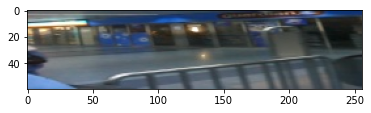

In [48]:
plt.imshow(cv2.imread(combined['im'].iloc[0]))

In [15]:
from ast import literal_eval

list_of_labels=[literal_eval(i) for i in combined['labels']]

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Icdar_recog['im'].values,Icdar_recog['labels'].values, test_size=0.01, random_state=42)

# Find appropriate length for padding and truncating

<AxesSubplot:>

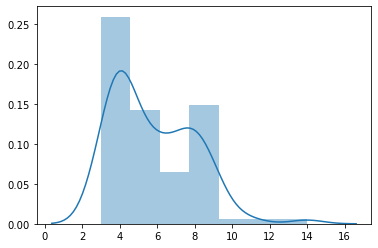

In [126]:
# tk=Tokenizer(char_level=True)
# tk.fit_on_texts(y_train)
# y_train_text=tk.texts_to_sequences(y_train)
# y_test_text=tk.texts_to_sequences(y_test)
import seaborn as sns
lengths=[len(i) for i in y_train]
sns.distplot(np.array(lengths))

In [127]:
list_y_train=[]
list_y_test=[]
for x in y_train:
    if len(x)<10:
        x.extend([0]*(10-len(x)))
    elif len(x)>10:
        x=x[:10]
    list_y_train.append(x)
for x in y_test:
    if len(x)<10:
        x.extend([0]*(10-len(x)))
    elif len(x)>10:
        x=x[:10]
    list_y_test.append(x)

In [223]:
def data_generator_for_recognition(x_data,y_data,batch_size=5):
    batch=0
    images=[]
    labels=[]
    for i,j in zip(x_data,y_data):
        try:
            i=i.decode('utf-8')
            im=cv2.imread(i)
            im = cv2.resize(im, dsize=(60, 256),interpolation = cv2.INTER_AREA)
            im=cv2.detailEnhance(im)
            im= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            
#             ret,thr = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
            im=im[:,:,np.newaxis]
            
#             img = tf.io.read_file(i)
#     # 2. Decode and convert to grayscale
#             img = tf.io.decode_png(img, channels=1)
#     # 3. Convert to float32 in [0, 1] range
#             img = tf.image.convert_image_dtype(img, tf.float32)
#     # 4. Resize to the desired size
#             img = tf.image.resize(img, [60, 256])
#     # 5. Transpose the image because we want the time
#     # dimension to correspond to the width of the image.
#             img = tf.transpose(img, perm=[1, 0, 2])
            images.append(im)
            labels.append(j)
            batch+=1
            if batch==batch_size:
                yield np.array(images,dtype=np.float32),np.array(labels,dtype=np.float32)
            
                images=[]
                labels=[]
                batch=0
         
        except Exception as e:
                import traceback
              
                traceback.print_exc()
                continue

In [224]:

dataset_rec = tf.data.Dataset.from_generator(
     data_generator_for_recognition,
     (tf.float32, tf.float32),
     args=(X_train,list_y_train,5))
dataset_rec = dataset_rec.cache()

In [225]:
for i in dataset_rec:
    print(i[0].shape)
    break

(5, 256, 60, 1)


# Recognition Model

In [8]:
rdir='C:\\Users\\Abhi\Desktop\\CS2\\icdar2013\\Challenge2_Training_Task12_Images\\'
images=return_names(rdir,'JPG')
rdir='C:\\Users\\Abhi\Desktop\\CS2\\icdar2013\\Challenge2_Training_Task1_GT\\'
gt=return_names(rdir,'txt')

root is C:\Users\Abhi\Desktop\CS2\icdar2013\Challenge2_Training_Task12_Images
root is C:\Users\Abhi\Desktop\CS2\icdar2013\Challenge2_Training_Task1_GT


In [176]:
list1,list3,bb=[],[],[]
for im,labels in zip(images['JPG'],gt['txt']):
    list1.append(im)
    f = open(labels, "r")
    list2=[]
    list4=[]
    for i in f.readlines():
         list4.append([int(x) for x in i.split()[:-1]])   
         list2.append(i.split()[-1].replace(" ",'')[1:-1])
    list3.append(list2)
    bb.append(list4)

In [39]:
df=pd.DataFrame({'JPG':list1,'bb':bb,'label':list3})
df.to_csv('13.csv')

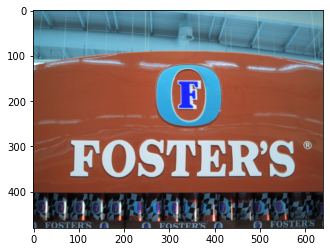

In [177]:
plt.imshow(cv2.imread(list1[2]))

In [174]:
for i in list3 :
    print(i)

['Footpath', 'To', 'Colchester', 'and', 'Greenstead']
['DELL']
['R', "FOSTER'S", "FOSTER'S", "FOSTER'S", 'O', 'F', "FOSTER'S"]
['STIRLING', 'CASTLE', "ARGYLL'S", 'LODGINGS']
['GOOD', 'HOME', 'MADE', 'FOOD', 'CASK', 'CONDITIONED', 'ALES', 'GARDEN']
['SCOTTISH', 'NATIONAL', 'GALLERY', 'MODERN']
['Information', 'Tickets', 'Trains']
['DANGER', 'CONSTRUCTION', 'SITE', 'Risk', 'of', 'Serious', 'Injury', 'KEEP', 'OUT', 'AND', 'KEEP', 'YOUR', 'CHILDREN', 'OUT!']
['arlboro', 'LIGHTS']
['SyncMaster', '213T']
['COLCHESTER']
['D']
['4B.528', '4B.526', '4B.524', '4B.522', 'YOU', 'ARE', 'HERE']
['CARLING']
['RYANAIR']
['MultiSync', 'LCD2470WVX']
['CORAL']
['Proceed', 'with', 'caution.', 'Height', 'when', 'raised', '115mm', '(412)']
['professional', 'Java', 'Web', 'Services']
['WAVEDOM']
['USE', 'ONLY', 'DRI-WIPE', 'MARKERS', 'ON', 'THESE', 'BOARDS']
['Central', 'Tyre', 'M.O.T.']
['COLCHESTER', 'POST', 'OFFICE']
['Knowledge', 'Management', '(KM)', '2.10', 'Oleg', 'Rostanin', 'Asif', 'Shahab']
['INVES

In [111]:
def generator_13(train, batch_size=12, random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2]),):
    
    count = 1
    images_with_label={}
    l=[]
    images=[]
    gt=np.array(train['bb'])
    
    index=range(train.shape[0])
    for i in tqdm(index):
            cropped=[]
            im_fn = np.array(train['JPG'])[i]
            im=cv2.imread(im_fn)
            labels=[]
            for bb,label in zip ( gt[i],train['label'][i]):
                try:
                    g=im[bb[1]:bb[3],bb[0]:bb[2]]
                    if len(g[0])==0:
                        continue
                    cropped.append(g)
                    labels.append(label_to_array(label))
                except ValueError:
                    print(labels)
                    plt.imshow(g)
                    continue
                  

            
       
            for x in cropped:   
                resize_h = 60
                resize_w = 64*4
           
                im = cv2.resize(x, dsize=(resize_w, resize_h),interpolation = cv2.INTER_AREA)
                cv2.imwrite('C:\\Users\\Abhi\\Desktop\\CS2\\icdar2015\Roi\\'+str(count)+'.jpg',im)
                images.append('C:\\Users\\Abhi\\Desktop\\CS2\\icdar2015\Roi\\'+str(count)+'.jpg')
             
                
                
                count+=1
            l.extend(labels)
          
            
    images_with_label['labels']=l
    images_with_label['im']=images
    return images_with_label

In [112]:
d=generator_13(df)


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [00:07<00:00, 32.61it/s]


In [113]:
len(d['im'])

848

In [114]:
df1=pd.DataFrame(d)
df1.head()

,labels,im
0,"[42, 25, 25, 30, 26, 11, 30, 18]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\1.jpg
1,"[57, 25]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\2.jpg
2,"[39, 25, 22, 13, 18, 15, 29, 30, 15, 28]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\3.jpg
3,"[11, 24, 14]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\4.jpg
4,"[43, 28, 15, 15, 24, 29, 30, 15, 11, 14]",C:\Users\Abhi\Desktop\CS2\icdar2015\Roi\5.jpg


In [6]:
inputs =Input(name='input', shape=(60,256,1), dtype='float32')  


# x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs) 
# x = MaxPool2D((2, 2), name="pool1")(x)

#     # Second conv block
# x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) 
# x = MaxPool2D((2, 2), name="pool2")(x)

# print(x.shape)

conv1 = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
x=Dropout(.2)
maxpool1 = MaxPool2D(pool_size=(2, 2), name='max1')(act1)  

conv2 = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(maxpool1)  
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
x=Dropout(.2)
maxpool2 = MaxPool2D(pool_size=(2, 2), name='max2')(act2) 

conv3 = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(maxpool2)  
bn3 = BatchNormalization()(conv3)
act3 =Activation('relu')(bn3)
x=Dropout(.2)
conv4 = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(act3)  
bn4 = BatchNormalization()(conv4)
act4 =Activation('relu')(bn4)
# maxpool3 = MaxPool2D(pool_size=(2, 2), name='max3')(act4)  
x=Dropout(.2)
conv5 = Conv2D(128, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(act4)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
x=Dropout(.2)
conv6 = Conv2D(128, (3, 3), padding='same', name='conv6')(act5)  
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
print(act6.shape)


conv7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='con7')(act6) 
print(conv7.shape)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)

# x = UpSampling2D(size=[2, 2],interpolation='bilinear')(act7)
print(act7.shape)
re1 = Reshape(target_shape=((64,15*256)), name='reshape')(act7)  

dense1 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(re1) 
x= Dropout(.2)
bidi1=Bidirectional(LSTM(128,return_sequences=True,go_backwards=True))(dense1)
out1=Bidirectional(LSTM(128,return_sequences=True,go_backwards=True))(bidi1)

out2=Dense(97,activation ='softmax')(out1)

recognizer=Model(inputs,out2)
recognizer.summary()

(None, 15, 64, 128)
(None, 15, 64, 256)
(None, 15, 64, 256)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 256, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 256, 32)       320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 60, 256, 32)       128       
_________________________________________________________________
activation_3 (Activation)    (None, 60, 256, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 30, 128, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 128, 64)       18496     
_________________________________________________________________

In [17]:
def ctc_loss(y_true,y_pred):
  
  #https://stackoverflow.com/questions/64321779/how-to-use-tf-ctc-loss-with-variable-length-features-and-labels

    label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
        
    
    return tf.keras.backend.ctc_batch_cost(y_true,y_pred,np.ones((10,1),'int32')*64,label_length)

In [21]:
recognizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001
                                                 ,amsgrad=True),loss=ctc_loss)

In [79]:
dataset_rec = tf.data.Dataset.from_generator(
     data_generator_for_recognition,
     (tf.float32, tf.float32),
     args=(X_train,list_y_train,10))
dataset_rec = dataset_rec.cache()

# dataset_rec_test = tf.data.Dataset.from_generator(
#      data_generator_for_recognition,
#      (tf.float32, tf.float32),
#      args=(X_test,list_y_test,10))
# dataset_rec_test = dataset_rec_test.cache()

In [219]:
for i in dataset_rec:
    print(i[0].shape)
    break

(10, 256, 60)


In [7]:
recognizer.load_weights('recog.h5')

In [23]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='recog_logs',write_images=True,histogram_freq=1,write_graph=False)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=6,mode='min',verbose=1)
modelchkpt=tf.keras.callbacks.ModelCheckpoint('recog1.h5',save_best_only=True,mode='min',monitor='loss')
g=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.5,patience=3,verbose=True)
callbacks=[tensorboard,early_stop,modelchkpt,g]


In [28]:
recognizer.fit(dataset_rec.repeat(),epochs=30,steps_per_epoch=len(X_train)/5,callbacks=callbacks)

Epoch 1/30
47/47 [==============================] - 24s 514ms/step - loss: 29.0174
Epoch 2/30
47/47 [==============================] - 23s 489ms/step - loss: 19.8860
Epoch 3/30
47/47 [==============================] - 23s 492ms/step - loss: 15.8201
Epoch 4/30
47/47 [==============================] - 24s 502ms/step - loss: 13.1251
Epoch 5/30
47/47 [==============================] - 24s 506ms/step - loss: 11.5445
Epoch 6/30
47/47 [==============================] - 24s 514ms/step - loss: 10.6765
Epoch 7/30
47/47 [==============================] - 24s 521ms/step - loss: 9.5489
Epoch 8/30
47/47 [==============================] - 24s 518ms/step - loss: 8.2977
Epoch 9/30
47/47 [==============================] - 24s 520ms/step - loss: 5.9459
Epoch 10/30
47/47 [==============================] - 25s 525ms/step - loss: 4.6699
Epoch 11/30
47/47 [==============================] - 25s 536ms/step - loss: 4.0374
Epoch 12/30
47/47 [==============================] - 26s 555ms/step - loss: 3.8237
Epoch 1

In [29]:
recognizer.save_weights('recog1.h5')

In [8]:
recognizer.save('recognizer.h5')

# Short Inferrence

# Synth

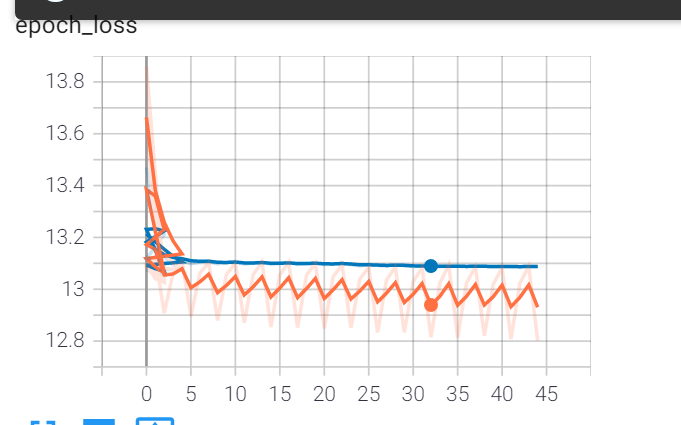

In [147]:
from IPython.display import Image
Image(filename='recog.png')

# Icdar

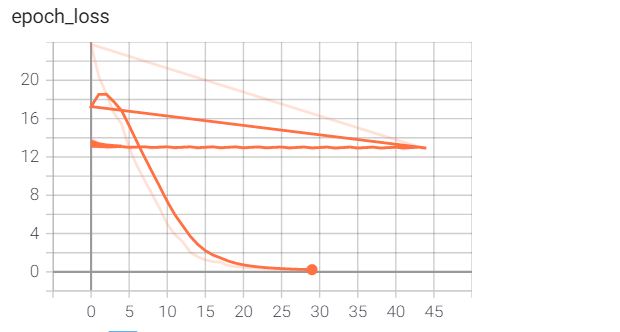

In [85]:
from IPython.display import Image
Image(filename='2.png')

# INFERENCE Functions

In [108]:
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    #print(geometry.shape)
    d = geometry[:, :4]
    #print(d.shape)
    angle = geometry[:, 4]
    # for angle > 0
    #print(angle)
    # print((angle>=0).shape)
    #print(origin)
    origin_0 = origin[angle >= 0]
    #print(origin_0.shape)
    d_0 = d[angle >= 0]
    #print(d_0.shape)
    #print(d_0)
    angle_0 = angle[angle >= 0]
    #print(angle_0.shape)
    #print(-d_0[:, 0] - d_0[:, 2])
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        #print(p.shape)
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2
#         print(p.shape)

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        # print(p_rotate_x)
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
        #print(origin_0)
        #print(new_p_0)
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_
def sort_rectangle(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # 底边平行于X轴, 那么p0为左上角 - if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # 找到最低点右边的点 - find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # 这个点为p2 - this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # 这个点为p3 - this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    #print(box)
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

import time

def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
    for g in polys:
        if p is not None and intersection(g, p) > thres:
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)

# Inferrence

In [120]:
# recognizer.load_weights('recog.h5')
def Inference(path):
    im=cv2.imread(path)
    im=cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)
    d.load_weights('detector_model.h5')
    recognizer.load_weights('recog.h5')
    pred=d.predict(im[np.newaxis,:,:,:])
    score_map=pred[0][:,:,0]
    
    geo_map=pred[0][:,:,1:]
    for ind in [0,1,2,3,4]:
        geo_map[:,:,ind]*=score_map
    score_map_thresh=0.2
    box_thresh=0.3
    nms_thres=0.05
    if len(score_map.shape) == 4:
   
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, :]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)

    # print(xy_text)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :])
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    boxes = nms_locality(boxes.astype(np.float64), nms_thres)
    # boxes = cv2.dnn.NMSBoxes(boxes, score_map, 0.3, (0.1))

    res = []
    result = []
    if len(boxes)>0:
        for box in boxes:
            box_ =  box[:8].reshape((4, 2))
            if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
                continue
            result.append(box_)
    res.append(np.array(result, np.float32))   
    #print(res)
    box_index = []
    brotateParas = []
    filter_bsharedFeatures = []
    for i in range(len(res)):
        rotateParas = []
        rboxes=res[i]
        txt=[]
        for j, rbox in enumerate(rboxes):
            # print(rbox)
            para = restore_roiRotatePara(rbox)
            #break
            if para and min(para[1][2:]) > 8:
                rotateParas.append(para)
                box_index.append((i, j))
        pts=[] 

    if len(rotateParas) > 0:
        for num in range(len(rotateParas)):
            text=""
            out=[]
            out1=rotateParas[num][0]
            for f in out1 :
            
                if f <0:
                    f=-1*f
                out.append(f)
        
            crop=rotateParas[num][1]
            points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
            angle=rotateParas[num][2] 
                #print(out)
#                 img1=tf.image.crop_to_bounding_box(img,out[1]-(int(out[1]*(5/100))),out[0]-(int(out[0]*(5/100))),out[3]+(int(out[3]*(55/100))),out[2]+(int(out[2]*(55/100))))
                # print(out)
            img1=tf.image.crop_to_bounding_box(im,out[1],out[0],out[3],out[2])
                #print(img1.shape)
#                 plt.imshow(img1)
#                 plt.show()
            img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
                
                #print(crop)
                #print(crop[0])
            img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
#                 plt.imshow(img2)
#                 plt.show()
            img2=cv2.resize(img2,(256,60))
            img2=cv2.detailEnhance(img2)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            ret,thr = cv2.threshold(img2, 0, 255, cv2.THRESH_OTSU)
            pred=recognizer.predict(thr[np.newaxis,:,:,np.newaxis])
            pred_arr=tf.keras.backend.ctc_decode(pred,np.ones((1),'int8')*64,)

            x=''
            for i in pred_arr[0][0][0]:
    
                if i== -1:
                    continue
                else:
                    x+=''.join(CHAR_VECTOR[i])
            txt.append(x)
            pts.append(points)  
    return pts,txt,im

In [121]:
u[0]

'C:\\Users\\Abhi\\Desktop\\CS2\\icdar2013\\Challenge2_Training_Task12_Images\\100.jpg'

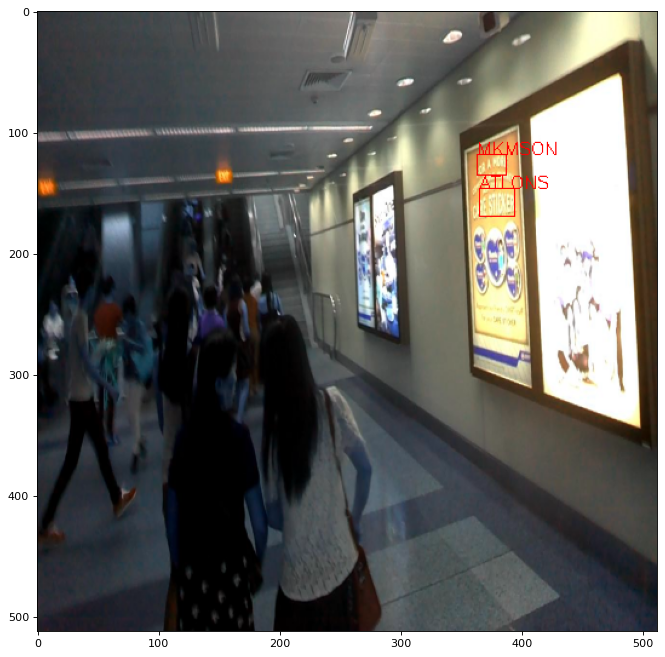

In [122]:

pts,txt,im= Inference(train['JPG'][4])
for i in range(len(txt)):
        
        
        cv2.polylines(im,[pts[i]],isClosed=True,color=(255,0,0),thickness=1)
        cv2.putText(im,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 1)
      

from matplotlib.pyplot import figure

figure(figsize=(10, 15), dpi=80)
    
plt.imshow(im)

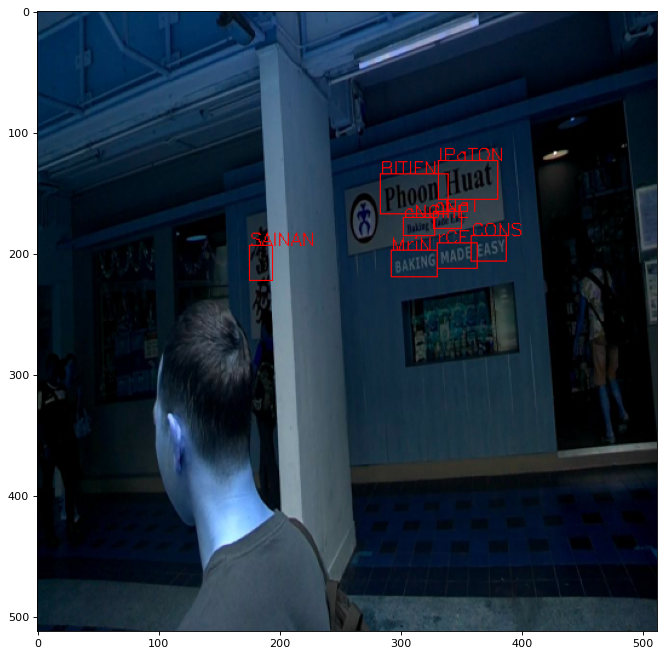

In [103]:
label=['score_map','top','left','bottom','right']
fig, ax = plt.subplots(2,4,figsize=(15,5))
for j in range(1):
    for k in range(4):
                ax[0,k].imshow(pred[0,::][:,:,0])             
                ax[1,k].imshow(i[1][0,::][:,:,0])
                ax[0,k].set_title('pred_'+label[k])            
                ax[1,k].set_title('true_'+label[k])      
                ax[0,k].axis("off")
                ax[1,k].axis('off')

# DUMMY OCR for proof

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1['im'].values,df1['labels'].values, test_size=0.01, random_state=42)

<AxesSubplot:>

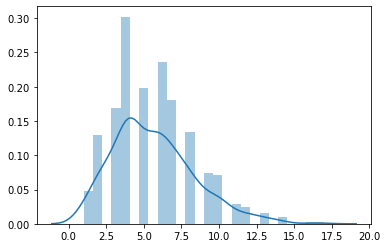

In [116]:
import seaborn as sns
lengths=[len(i) for i in y_train]
sns.distplot(np.array(lengths))

In [117]:
list_y_train=[]
list_y_test=[]
for x in y_train:
    if len(x)<12:
        x.extend([0]*(12-len(x)))
    elif len(x)>12:
        x=x[:12]
    list_y_train.append(x)
for x in y_test:
    if len(x)<12:
        x.extend([0]*(12-len(x)))
    elif len(x)>12:
        x=x[:12]
    list_y_test.append(x)

In [235]:
inputs =Input(name='input', shape=(60,256,1), dtype='float32')  


# x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs) 
# x = MaxPool2D((2, 2), name="pool1")(x)

#     # Second conv block
# x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x) 
# x = MaxPool2D((2, 2), name="pool2")(x)

# print(x.shape)

conv1 = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
x=Dropout(.2)
maxpool1 = MaxPool2D(pool_size=(2, 2), name='max1')(act1)  

conv2 = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(maxpool1)  
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
x=Dropout(.2)
maxpool2 = MaxPool2D(pool_size=(2, 2), name='max2')(act2) 

conv3 = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(maxpool2)  
bn3 = BatchNormalization()(conv3)
act3 =Activation('relu')(bn3)
x=Dropout(.2)
conv4 = Conv2D(128, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(act3)  
bn4 = BatchNormalization()(conv4)
act4 =Activation('relu')(bn4)
# maxpool3 = MaxPool2D(pool_size=(2, 2), name='max3')(act4)  
x=Dropout(.2)
conv5 = Conv2D(128, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(act4)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
x=Dropout(.2)
conv6 = Conv2D(128, (3, 3), padding='same', name='conv6')(act5)  
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
print(act6.shape)


conv7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='con7')(act6) 
print(conv7.shape)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)

# x = UpSampling2D(size=[2, 2],interpolation='bilinear')(act7)
print(act7.shape)
re1 = Reshape(target_shape=((64,15*256)), name='reshape')(act7)  

dense1 = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(re1) 
x= Dropout(.2)
bidi1=Bidirectional(LSTM(128,return_sequences=True,go_backwards=True))(dense1)
out1=Bidirectional(LSTM(128,return_sequences=True,go_backwards=True))(bidi1)

out2=Dense(97,activation ='softmax')(out1)

dummy=Model(inputs,out2)
dummy.summary()

(None, 15, 64, 128)
(None, 15, 64, 256)
(None, 15, 64, 256)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 256, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 256, 32)       320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 60, 256, 32)       128       
_________________________________________________________________
activation_21 (Activation)   (None, 60, 256, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 30, 128, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 128, 64)       18496     
_________________________________________________________________

In [119]:
dummy.load_weights('recog1.h5')

In [230]:

dataset_rec = tf.data.Dataset.from_generator(
     data_generator_for_recognition,
     (tf.float32, tf.float32),
     args=(X_train,list_y_train,10))
dataset_rec = dataset_rec.cache()

In [231]:
def ctc_loss(y_true,y_pred):
  
  #https://stackoverflow.com/questions/64321779/how-to-use-tf-ctc-loss-with-variable-length-features-and-labels

    label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
        
    
    return tf.keras.backend.ctc_batch_cost(y_true,y_pred,np.ones((10,1),'int32')*15,label_length)

In [232]:
dummy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001
                                                 ,amsgrad=True),loss=ctc_loss)
dataset_rec = tf.data.Dataset.from_generator(
     data_generator_for_recognition,
     (tf.float32, tf.float32),
     args=(X_train,list_y_train,10))
dataset_rec = dataset_rec.cache()

# dataset_rec_test = tf.data.Dataset.from_generator(
#      data_generator_for_recognition,
#      (tf.float32, tf.float32),
#      args=(X_test,list_y_test,10))
# dataset_rec_test = dataset_rec_test.cache()

In [233]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='recog_logs',write_images=True,histogram_freq=1,write_graph=False)
early_stop=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=6,mode='min',verbose=1)
modelchkpt=tf.keras.callbacks.ModelCheckpoint('ic.h5',save_best_only=True,mode='min',monitor='loss')
g=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.5,patience=3,verbose=True)
callbacks=[tensorboard,early_stop,modelchkpt,g]


In [234]:
dummy.fit(dataset_rec.repeat(),epochs=30,steps_per_epoch=len(X_train)//14,callbacks=callbacks)

Epoch 1/30
59/59 [==============================] - 36s 532ms/step - loss: 39.2351
Epoch 2/30
59/59 [==============================] - 32s 534ms/step - loss: 25.4912
Epoch 3/30
59/59 [==============================] - 32s 539ms/step - loss: 24.5236
Epoch 4/30
59/59 [==============================] - 32s 542ms/step - loss: 22.1969
Epoch 5/30
59/59 [==============================] - 33s 559ms/step - loss: 22.8692
Epoch 6/30
59/59 [==============================] - 33s 551ms/step - loss: 23.4857
Epoch 7/30
59/59 [==============================] - 32s 550ms/step - loss: 21.6259
Epoch 8/30
59/59 [==============================] - 33s 556ms/step - loss: 22.7645
Epoch 9/30
14/59 [======>.......................] - ETA: 26s - loss: 22.5154

KeyboardInterrupt: 

In [179]:
dummy.save_weights('13.h5')

In [180]:
list1=[]
list2=[]
for i,j  in zip(df1['im'],df1['labels']):
    img=cv2.imread(i,0)
    img = cv2.resize(img, dsize=(256, 60),interpolation = cv2.INTER_AREA)
    ret,thr = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)

    thr=thr[:,:,np.newaxis]
    pred=dummy.predict(thr[np.newaxis,:,:,:])
    
    pred_arr=tf.keras.backend.ctc_decode(pred,np.ones((15),'int8')*64,)
    x=''
    for  k in pred_arr[0][0][0][:10]: # literal_eval(combined['labels'][0]):       # Predicted

        if i== -1:
            continue
        else:
            x+=''.join(CHAR_VECTOR[k])
    y=''
    for  k in j:                      #literal_eval(combined['labels'][0]):        # True
        if k== -1:  
            continue
        else:
            y+=''.join(CHAR_VECTOR[k])
    list1.append(x)
    list2.append(y)
   

In [186]:
import seaborn as sns
metric=[]
for x,y in zip(list1,list2):
    metric.append(distance(y,x))


In [187]:
for i in metric :
    print(i)

12
12
12
11
12
12
12
10
12
12
12
12
10
12
10
12
9
12
12
12
12
12
11
12
11
9
11
11
10
12
12
12
11
12
12
12
12
12
12
11
12
12
11
12
11
12
12
12
11
12
12
12
12
12
12
12
12
12
11
12
12
12
12
12
11
12
12
12
12
11
12
12
12
12
12
12
12
12
12
12
11
12
12
12
12
12
12
11
11
11
12
12
12
12
12
11
12
12
10
11
12
11
11
12
12
12
12
12
11
12
12
12
12
12
12
12
12
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
11
12
11
11
12
12
12
12
11
12
12
12
12
12
12
11
12
12
11
12
12
12
11
12
12
12
12
11
12
12
12
11
11
11
11
12
12
11
12
12
12
12
12
12
12
12
11
12
12
12
11
12
12
12
12
12
12
12
12
12
12
12
11
12
12
12
12
12
12
12
12
12
12
12
12
11
12
12
11
12
12
11
12
12
12
12
12
12
12
12
11
12
12
12
11
12
12
12
11
12
11
11
12
12
12
11
12
12
12
12
12
12
12
12
11
12
11
11
12
12
12
13
12
12
11
11
12
12
11
11
12
13
12
12
12
11
12
11
12
12
12
12
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
12
12
12
12
12
12
12
11
12
12
12
11
12
12
12
12
12
12
12
12
12
12
12
11
12
13
12
12
11
12
11
12
12
12
12
12
11
12
12
11
10
11


In [197]:
for i, j in zip(list1,list2):
    print(i,j)

SITI"""""" Footpath####
INEi"""""" To##########
RTE""""""" Colchester##
nxR""""""" and#########
RECT"""""" Greenstead##
TRTSa""""" DELL########
GErleu"""" R###########
GPSE"""""" FOSTER'S####
GaG-ST"""" FOSTER'S####
TG"""""""" FOSTER'S####
FRaRldehaN O###########
RGta"""""" F###########
TEACES"""" FOSTER'S####
GEE""""""" STIRLING####
GETRTLENR" CASTLE######
SPMEH""""" ARGYLL'S####
TGPINSE""" LODGINGS####
LiB9sea""" GOOD########
PielGE"""" HOME########
BeOeek"""" MADE########
ErsPj""""" FOOD########
TONR"""""" CASK########
PN"""""""" CONDITIONED#
ONLcET"""" ALES########
FWRPeS"""" GARDEN######
POTOS""""" SCOTTISH####
RTP""""""" NATIONAL####
TIPYYEe""" GALLERY#####
MEPO"""""" MODERN######
RNIEE""""" Information#
IGK1E""""" Tickets#####
ROHP"""""" Trains######
EPNY"""""" DANGER######
0REEP""""" CONSTRUCTION
EHaSisde"" SITE########
PE4oe""""" Risk########
BFae"""""" of##########
GUOaO""""" Serious#####
ll1ek""""" Injury######
MEASx""""" KEEP########
FOa7!""""" OUT#########
W""""""""" AND##

In [189]:
list2[4]

'Greenstead##'

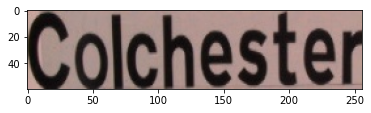

In [131]:
plt.imshow(cv2.imread(df1['im'].iloc[2]))

In [214]:

im,txt=[],[]
for i in  df1['im'].iloc[1:8]:
            
            img=cv2.imread(i)
            img2=cv2.resize(img/255,(256,60))
            img2=cv2.detailEnhance(img2)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            ret,thr = cv2.threshold(img2, 0, 255, cv2.THRESH_OTSU)
            pred=dummy.predict(thr[np.newaxis,:,:,np.newaxis])
            pred_arr=tf.keras.backend.ctc_decode(pred,np.ones((1),'int8')*64,greedy=True)

            x=''
            for i in pred_arr[0][0][0]:
    
                if i== -1:
                    continue
                else:
                    x+=''.join(CHAR_VECTOR[i])
            txt.append(x)
            im.append(img)
            

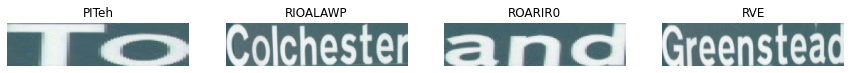

In [215]:
label=txt
fig, ax = plt.subplots(1,4,figsize=(15,5))

for k in range(4):
                ax[k].imshow(im[k]*255)             
                
                ax[k].set_title(label[k])            
                 
                ax[k].axis("off")
              